Now let's do the actual machine learning, but there are some things we have to finish before the actual modeling

In [1]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
import pickle as pkl
from collections import Counter
from imblearn.over_sampling import SMOTE
import random
import numpy as np

Let's start with our final preprocessing steps
We are going to:
* Get rid of our extraneous column left behind due saving and rereading our data
* Set our proper index so that each row is proprtly identifiable

In [2]:
#read in the data
df=pd.read_csv('Data/toronto_covid_cleaned.csv')

In [3]:
#drop the useless column
df.drop(['Unnamed: 0'],axis=1, inplace=True)

In [4]:
#set index to the id of the person
df.set_index('_id',inplace=True)

In [5]:
df

,Outbreak Associated,Age Group,Neighbourhood Name,FSA,Source of Infection,Classification,Client Gender,Outcome,Ever Hospitalized,Ever in ICU,Ever Intubated,episode_vs_reported_int,Episode_Month,Reported_Month
_id,,,,,,,,,,,,,,
44294,Sporadic,50-59,Malvern,M1B,Institutional,CONFIRMED,MALE,RESOLVED,No,No,No,2,3,3
44295,Sporadic,20-29,Malvern,M1B,Community,CONFIRMED,MALE,RESOLVED,Yes,No,No,8,3,3
44296,Sporadic,60-69,Malvern,M1B,Travel,CONFIRMED,FEMALE,RESOLVED,Yes,Yes,Yes,4,3,3
44297,Outbreak Associated,50-59,Rouge,M1B,N/A - Outbreak associated,CONFIRMED,FEMALE,RESOLVED,No,No,No,2,5,5
44298,Sporadic,30-39,Rouge,M1B,Close contact,CONFIRMED,FEMALE,RESOLVED,No,No,No,6,5,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58587,Sporadic,50-59,West Humber-Clairville,M9W,Close contact,CONFIRMED,FEMALE,RESOLVED,No,No,No,5,5,5
58588,Sporadic,30-39,West Humber-Clairville,M9W,Close contact,CONFIRMED,MALE,RESOLVED,No,No,No,4,4,4
58589,Sporadic,20-29,West Humber-Clairville,M9W,Community,CONFIRMED,FEMALE,RESOLVED,No,No,No,3,5,5


Now let's handle our categorical variables
* We use a LabelEncoder for the categorical data with an order associated with it
* We use the OneHotEncoder for categorical data without an order associated with it

In [6]:
#Create the stringindexer function for each ordered field
def stringindexer(field,df):
    #create dictionary
    map_dict=dict()
    #iterate through the field
    for i,j in enumerate(list(set(df[field]))):
        #create dictionary
        map_dict[i]=j
    return map_dict

We split up the datasets based on each datatype
* label input - categorical with order
* one hot input - cateogrical without order
* numerical input - continouse variables
* output - our output column

In [7]:
#Seperate columns into different outputs
categorical_label_input=['Age Group','Episode_Month','Reported_Month']
categorical_one_hot_input=['Outbreak Associated','Neighbourhood Name','FSA','Source of Infection','Client Gender','Ever Hospitalized','Ever in ICU','Ever Intubated']
numerical_input=['episode_vs_reported_int']
output=['Outcome']


In [8]:
df[categorical_one_hot_input]

,Outbreak Associated,Neighbourhood Name,FSA,Source of Infection,Client Gender,Ever Hospitalized,Ever in ICU,Ever Intubated
_id,,,,,,,,
44294,Sporadic,Malvern,M1B,Institutional,MALE,No,No,No
44295,Sporadic,Malvern,M1B,Community,MALE,Yes,No,No
44296,Sporadic,Malvern,M1B,Travel,FEMALE,Yes,Yes,Yes
44297,Outbreak Associated,Rouge,M1B,N/A - Outbreak associated,FEMALE,No,No,No
44298,Sporadic,Rouge,M1B,Close contact,FEMALE,No,No,No
...,...,...,...,...,...,...,...,...
58587,Sporadic,West Humber-Clairville,M9W,Close contact,FEMALE,No,No,No
58588,Sporadic,West Humber-Clairville,M9W,Close contact,MALE,No,No,No
58589,Sporadic,West Humber-Clairville,M9W,Community,FEMALE,No,No,No


In [9]:
set(df['Outcome'])

{'FATAL', 'RESOLVED'}

Now let's execute these encoders
It helps to save each type of encoder to you create

Let's first execute our Label Encoders
* We execute it and first save our output variables
* We execute it on each of th enecessary variables
* We save our encoders for the dahsboard 
* We make each model an entry in a dictionary to expedite the process 

In [10]:
#instantiate label encoder
encoded_data=dict()
def encode_outcome(outcome_list):
    #empty list
    outcome_encoded=[]
    #iterate through outcome list
    for i in df['Outcome']:
        #if fatal append 1
        if i== 'FATAL':
            outcome_encoded.append(1)
        else:
            #else append 0
            outcome_encoded.append(0)
    return outcome_encoded

encoded_data[output[0]]=encode_outcome(df['Outcome'])
output_df=pd.DataFrame(encoded_data)

There's a simpler way to do this

In [11]:
output_df['id']=df.index

In [12]:
output_df

,Outcome,id
0,0,44294
1,0,44295
2,0,44296
3,0,44297
4,0,44298
...,...,...
13298,0,58587
13299,0,58588
13300,0,58589
13301,0,58590


In [13]:
#create the encoder dictionary
encoded_data=dict()
model_dict=dict()
for i in categorical_label_input:
    #instantiate the label encoder
    le=LabelEncoder()
    #create the encoder
    label_model=le.fit(df[i])
    #add the encoder to the dictionary
    model_dict[i]=label_model
    #transform data
    label_data=label_model.transform(df[i])
    #add label data to the dictionary
    encoded_data[i]=label_data
#Create the dataframe
label_df=pd.DataFrame(encoded_data)

In [14]:
#set indexer
label_df['id']=df.index

Now let's execute the one hot encoder
One model can be executed on all the proper columns
This can then be immediately saved for the dashboard
We have to get the column names and create the dataframe to join
We join the datasets

In [15]:
#instantiate the encoder
ohe=OneHotEncoder()
#fit the encoder
ohe_model=ohe.fit(df[categorical_one_hot_input])
#create the encoded data
ohe_data=ohe_model.transform(df[categorical_one_hot_input])
#save the sparse matrix to the dense array
dense_array=ohe_data.toarray()

In [16]:
#get column names
features=ohe.get_feature_names_out(categorical_one_hot_input)

In [17]:
#turn into a dataframe and add the feature names 
one_hot_df=pd.DataFrame(dense_array)
one_hot_df.columns=features

In [18]:
one_hot_df['id']=df.index

In [19]:
#join the encoded data
df_label_one_hot=one_hot_df.merge(label_df,left_on='id',right_on='id')

In [20]:
#further join the encoded data
df_final_preprocessed=df_label_one_hot.merge(output_df,left_on='id',right_on='id').set_index('id')

In [21]:
#let's make a copy for later
df_smote_set=df_final_preprocessed

Now let's start making sure properly represent underrepresente values

In [22]:
df_final_preprocessed

,Outbreak Associated_Outbreak Associated,Outbreak Associated_Sporadic,Neighbourhood Name_Agincourt North,Neighbourhood Name_Agincourt South-Malvern West,Neighbourhood Name_Alderwood,Neighbourhood Name_Annex,Neighbourhood Name_Banbury-Don Mills,Neighbourhood Name_Bathurst Manor,Neighbourhood Name_Bay Street Corridor,Neighbourhood Name_Bayview Village,...,Ever Hospitalized_No,Ever Hospitalized_Yes,Ever in ICU_No,Ever in ICU_Yes,Ever Intubated_No,Ever Intubated_Yes,Age Group,Episode_Month,Reported_Month,Outcome
id,,,,,,,,,,,,,,,,,,,,,
44294,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,4,2,2,0
44295,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,1,2,2,0
44296,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,5,2,2,0
44297,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,4,4,4,0
44298,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,2,4,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58587,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,4,4,4,0
58588,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,2,3,3,0
58589,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1,4,4,0


In [23]:
#only fatal entries
df_fatal=df_final_preprocessed[df_final_preprocessed['Outcome']==0]

In [24]:
df_fatal

,Outbreak Associated_Outbreak Associated,Outbreak Associated_Sporadic,Neighbourhood Name_Agincourt North,Neighbourhood Name_Agincourt South-Malvern West,Neighbourhood Name_Alderwood,Neighbourhood Name_Annex,Neighbourhood Name_Banbury-Don Mills,Neighbourhood Name_Bathurst Manor,Neighbourhood Name_Bay Street Corridor,Neighbourhood Name_Bayview Village,...,Ever Hospitalized_No,Ever Hospitalized_Yes,Ever in ICU_No,Ever in ICU_Yes,Ever Intubated_No,Ever Intubated_Yes,Age Group,Episode_Month,Reported_Month,Outcome
id,,,,,,,,,,,,,,,,,,,,,
44294,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,4,2,2,0
44295,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,1,2,2,0
44296,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,5,2,2,0
44297,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,4,4,4,0
44298,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,2,4,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58587,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,4,4,4,0
58588,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,2,3,3,0
58589,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1,4,4,0


In [25]:
#only resolved entries
df_resolved=df_final_preprocessed[df_final_preprocessed['Outcome']==1]

In [26]:
df_resolved

,Outbreak Associated_Outbreak Associated,Outbreak Associated_Sporadic,Neighbourhood Name_Agincourt North,Neighbourhood Name_Agincourt South-Malvern West,Neighbourhood Name_Alderwood,Neighbourhood Name_Annex,Neighbourhood Name_Banbury-Don Mills,Neighbourhood Name_Bathurst Manor,Neighbourhood Name_Bay Street Corridor,Neighbourhood Name_Bayview Village,...,Ever Hospitalized_No,Ever Hospitalized_Yes,Ever in ICU_No,Ever in ICU_Yes,Ever Intubated_No,Ever Intubated_Yes,Age Group,Episode_Month,Reported_Month,Outcome
id,,,,,,,,,,,,,,,,,,,,,
44308,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,7,3,3,1
44642,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,8,3,4,1
44643,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,7,3,4,1
44647,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,8,3,3,1
44653,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,6,3,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58381,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,7,2,3,1
58382,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,7,2,3,1
58384,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,7,2,3,1


In [27]:
#Even out the data entires
#get the ids for our overall dataset
df_true_list=[]
for i in ['Ever Intubated_Yes','Ever in ICU_Yes','Ever Hospitalized_Yes','Outcome']:
    #snatch positives take from set, move on repeat, ensure these are included in final
    df_true=df_final_preprocessed[df_final_preprocessed[i]==1]
    if i=='Outcome':
        df_true=df_final_preprocessed[df_final_preprocessed[i]==0]
    ids=list(df_true.index)
    df_final_preprocessed=df_final_preprocessed[~df_final_preprocessed.index.isin(ids)]
    df_true_list.append(df_true)
full_filtered=pd.concat(df_true_list)

In [28]:
full_filtered

,Outbreak Associated_Outbreak Associated,Outbreak Associated_Sporadic,Neighbourhood Name_Agincourt North,Neighbourhood Name_Agincourt South-Malvern West,Neighbourhood Name_Alderwood,Neighbourhood Name_Annex,Neighbourhood Name_Banbury-Don Mills,Neighbourhood Name_Bathurst Manor,Neighbourhood Name_Bay Street Corridor,Neighbourhood Name_Bayview Village,...,Ever Hospitalized_No,Ever Hospitalized_Yes,Ever in ICU_No,Ever in ICU_Yes,Ever Intubated_No,Ever Intubated_Yes,Age Group,Episode_Month,Reported_Month,Outcome
id,,,,,,,,,,,,,,,,,,,,,
44296,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,5,2,2,0
44341,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,4,5,5,0
44381,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,4,2,2,0
44466,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,6,3,3,0
44470,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,6,3,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58586,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,2,3,3,0
58587,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,4,4,4,0
58588,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,2,3,3,0


In [29]:
#let's randomly select the non fatal for our set
random_ids=[]
for i in range(3000):
    #get random numbers in the indices
    random_numbers=random.randint(0,len(df_final_preprocessed.index)-1)
    #append random numbers to a list
    random_ids.append(df_final_preprocessed.index[random_numbers])
#get randomly selected indices
leftover=df_final_preprocessed[df_final_preprocessed.index.isin(random_ids)]

In [30]:
full_df=pd.concat([full_filtered,leftover])

In [31]:
full_df

,Outbreak Associated_Outbreak Associated,Outbreak Associated_Sporadic,Neighbourhood Name_Agincourt North,Neighbourhood Name_Agincourt South-Malvern West,Neighbourhood Name_Alderwood,Neighbourhood Name_Annex,Neighbourhood Name_Banbury-Don Mills,Neighbourhood Name_Bathurst Manor,Neighbourhood Name_Bay Street Corridor,Neighbourhood Name_Bayview Village,...,Ever Hospitalized_No,Ever Hospitalized_Yes,Ever in ICU_No,Ever in ICU_Yes,Ever Intubated_No,Ever Intubated_Yes,Age Group,Episode_Month,Reported_Month,Outcome
id,,,,,,,,,,,,,,,,,,,,,
44296,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,5,2,2,0
44341,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,4,5,5,0
44381,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,4,2,2,0
44466,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,6,3,3,0
44470,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,6,3,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58378,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,7,3,3,1
58381,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,7,2,3,1
58382,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,7,2,3,1


In [32]:
full_df.groupby('Outcome').count()

,Outbreak Associated_Outbreak Associated,Outbreak Associated_Sporadic,Neighbourhood Name_Agincourt North,Neighbourhood Name_Agincourt South-Malvern West,Neighbourhood Name_Alderwood,Neighbourhood Name_Annex,Neighbourhood Name_Banbury-Don Mills,Neighbourhood Name_Bathurst Manor,Neighbourhood Name_Bay Street Corridor,Neighbourhood Name_Bayview Village,...,Client Gender_OTHER,Ever Hospitalized_No,Ever Hospitalized_Yes,Ever in ICU_No,Ever in ICU_Yes,Ever Intubated_No,Ever Intubated_Yes,Age Group,Episode_Month,Reported_Month
Outcome,,,,,,,,,,,,,,,,,,,,,
0,12284,12284,12284,12284,12284,12284,12284,12284,12284,12284,...,12284,12284,12284,12284,12284,12284,12284,12284,12284,12284
1,1017,1017,1017,1017,1017,1017,1017,1017,1017,1017,...,1017,1017,1017,1017,1017,1017,1017,1017,1017,1017


Now let's get into the training, we first split into training and testing sets
Then start executing the model

In [33]:
from sklearn.model_selection import train_test_split
#split data into train and testing set
full_df=full_df.sample(frac=1)
#drop the output variable
X=full_df.drop('Outcome',axis=1)
#set the output varibale to y
y=full_df['Outcome']
#split the data
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

Now let's get an idea of which modeling algorithm works best with our data

Let's first look into some transparent algorithsm like logistic regressions and decision trees

In [34]:
#execute the logistic regression
#instantiate a mode
lg=LogisticRegression()
#fit the model
lg_model=lg.fit(X_train,y_train)
#predict values
lg_preds=lg_model.predict(X_test)
#assess accuracy
accuracy_score(lg_preds,y_test)

C:\Users\baker\Anaconda3\envs\my-env\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9240886884629839

Let's take a look at the coeffcients to see how they contribute to the decision

In [35]:
#feature names
features=lg.feature_names_in_

In [36]:
#coefficients values 
values=lg_model.coef_

In [37]:
#creation of the coefficient df
coef_df=pd.DataFrame({'features':features,'coefficents':abs(values[0])})

In [38]:
#display the coefficient df
coef_df.sort_values('coefficents',ascending=False)[0:20]

,features,coefficents
249,Ever Hospitalized_No,1.422961
11,Neighbourhood Name_Bedford Park-Nortown,1.365312
27,Neighbourhood Name_Clanton Park,1.226151
7,Neighbourhood Name_Bathurst Manor,1.183293
253,Ever Intubated_No,1.155458
142,FSA_M1B,1.142729
6,Neighbourhood Name_Banbury-Don Mills,1.079915
220,FSA_M6P,1.054899
99,Neighbourhood Name_Playter Estates-Danforth,1.054143
251,Ever in ICU_No,1.048940


Now let's see how to use Decision Tree's transparency

In [39]:
#execute decision tree
dt=DecisionTreeClassifier()
#fit model
dt_model=dt.fit(X_train,y_train)
#make predictions
dt_preds=dt_model.predict(X_test)
#assess accuracy 
accuracy_score(dt_preds,y_test)

0.9240886884629839

[Text(0.4730535153541625, 0.9871794871794872, 'X[255] <= 5.5\ngini = 0.14\nsamples = 10640\nvalue = [9837, 803]'),
 Text(0.1600671057844691, 0.9615384615384616, 'X[253] <= 0.5\ngini = 0.028\nsamples = 8019\nvalue = [7906, 113]'),
 Text(0.0659270998415214, 0.9358974358974359, 'X[255] <= 4.5\ngini = 0.493\nsamples = 118\nvalue = [66, 52]'),
 Text(0.05071315372424723, 0.9102564102564102, 'X[242] <= 0.5\ngini = 0.427\nsamples = 68\nvalue = [47, 21]'),
 Text(0.041838351822503964, 0.8846153846153846, 'X[240] <= 0.5\ngini = 0.391\nsamples = 60\nvalue = [44, 16]'),
 Text(0.03169572107765452, 0.8589743589743589, 'X[148] <= 0.5\ngini = 0.31\nsamples = 47\nvalue = [38, 9]'),
 Text(0.026624405705229795, 0.8333333333333334, 'X[151] <= 0.5\ngini = 0.268\nsamples = 44\nvalue = [37, 7]'),
 Text(0.024088748019017434, 0.8076923076923077, 'X[150] <= 0.5\ngini = 0.24\nsamples = 43\nvalue = [37, 6]'),
 Text(0.021553090332805072, 0.782051282051282, 'X[7] <= 0.5\ngini = 0.21\nsamples = 42\nvalue = [37, 5]'),

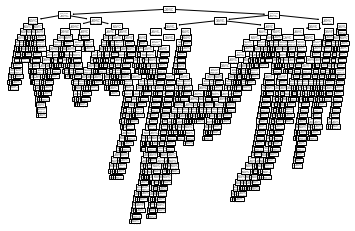

In [40]:
from sklearn import tree
tree.plot_tree(dt_model)

This can allow you to see the splits that occured within your tree, now let's take a look at the feature importances

In [41]:
#get feature names
dt_feature_names=dt.feature_names_in_

In [42]:
#get feature importances
features_dt=dt_model.feature_importances_

In [43]:
#get importances df 
coef_df=pd.DataFrame({'features':dt_feature_names,'coefficents':abs(features_dt)})

In [44]:
#display importance df
coef_df.sort_values('coefficents',ascending=False)[0:20]

,features,coefficents
255,Age Group,0.295503
250,Ever Hospitalized_Yes,0.062659
257,Reported_Month,0.054647
256,Episode_Month,0.048231
253,Ever Intubated_No,0.041716
247,Client Gender_MALE,0.025563
246,Client Gender_FEMALE,0.019097
1,Outbreak Associated_Sporadic,0.016685
60,Neighbourhood Name_Islington-City Centre West,0.014781
252,Ever in ICU_Yes,0.012756


Support Vector Machines is a felxible algorithm that seperates data on a plane, the function this algorithm uses to seperate values can be selected, by the user

In [45]:
#execute support vector machines
svm=SVC()
#fit model
svm_model=svm.fit(X_train,y_train)
#make predictions
svm_preds=svm_model.predict(X_test)
#assess accuracy
accuracy_score(svm_preds,y_test)

0.923337091319053

In [46]:
#display parameters
svm_model.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

Our current kernel is the RBF function or radial basis function other options include linear, poly, sigmoid

If we want some transparancey with the model we can use a linear kernel

In [47]:
#execute support vector machines
svml=SVC(kernel='linear')
#fit model
svml_model=svml.fit(X_train,y_train)
#make predictions
svml_preds=svml_model.predict(X_test)
#assess accuracy
accuracy_score(svml_preds,y_test)

0.9214580984592259

In [48]:
#get linear svm features
svml_features_names=svm_model.feature_names_in_

In [49]:
#get linear svm coefficients 
svml_coefs=svml_model.coef_[0]

In [50]:
#get coefficient df
coef_df=pd.DataFrame({'features':svml_features_names,'coefficents':abs(svml_coefs)})

In [51]:
#display coefficient df 
coef_df.sort_values('coefficents',ascending=False)[0:20]

,features,coefficents
27,Neighbourhood Name_Clanton Park,1.497665
11,Neighbourhood Name_Bedford Park-Nortown,1.000000
61,Neighbourhood Name_Junction Area,1.000000
96,Neighbourhood Name_Palmerston-Little Italy,1.000000
58,Neighbourhood Name_Humewood-Cedarvale,0.956656
125,Neighbourhood Name_West Hill,0.934875
220,FSA_M6P,0.928719
9,Neighbourhood Name_Bayview Village,0.904730
110,Neighbourhood Name_Scarborough Village,0.901761
53,Neighbourhood Name_Highland Creek,0.898887


Now let's execute random forest, to note, we can get feature importances based on all the trees, but this will not give you the same certainty as the decision tree

In [52]:
#Execute random forest
rf=RandomForestClassifier()
#fit model
rf_model=rf.fit(X_train,y_train)
#make predictions
rf_pred=rf.predict(X_test)
#assess accuracy 
accuracy_score(y_test,rf_pred)

0.9248402856069147

Now we can actually get our feature importances for random forest

In [53]:
#get random forest features
rf_feature_names=dt.feature_names_in_

In [54]:
#get feature importances
features_rf=rf_model.feature_importances_

In [55]:
#get coefficinet df
coef_df=pd.DataFrame({'features':rf_feature_names,'coefficents':abs(features_rf)})

In [56]:
#display the feature importance df
coef_df.sort_values('coefficents',ascending=False)[0:20]

,features,coefficents
255,Age Group,0.235216
249,Ever Hospitalized_No,0.053982
256,Episode_Month,0.050882
257,Reported_Month,0.046025
250,Ever Hospitalized_Yes,0.041951
246,Client Gender_FEMALE,0.023355
247,Client Gender_MALE,0.023247
1,Outbreak Associated_Sporadic,0.021845
0,Outbreak Associated_Outbreak Associated,0.020528
242,Source of Infection_N/A - Outbreak associated,0.018577


Finally, we have the XGBoost classifier, a popular and powerful machine learning method

In [57]:
#execute the gradient boosting methods
xgb=XGBClassifier()
#fit model
xgb_model=xgb.fit(X_train,y_train)
#make predictions
xgb_preds=xgb_model.predict(X_test)
#assess accuracy
accuracy_score(xgb_preds,y_test)

0.9248402856069147

Similar to the SVC algorithms, XGBoost has the ability for you to define a booster, which will allow you to see the coefficients 

In [58]:
#execute the gradient boosting methods
lxgb=XGBClassifier(booster='gblinear')
#fit model
lxgb_model=lxgb.fit(X_train,y_train)
#make predictions
lxgb_preds=lxgb_model.predict(X_test)
#assess accuracy
accuracy_score(lxgb_preds,y_test)

0.920706501315295

In [59]:
#get linear xgboost feature names
lxgb_feature_names=lxgb.feature_names_in_

In [60]:
#ge tlinear xgboost feature importances
features_lxgb=lxgb_model.feature_importances_

In [61]:
#create coefficient df
coef_df=pd.DataFrame({'features':lxgb_feature_names,'coefficents':abs(features_lxgb)})

In [62]:
#display coefficient df
coef_df.sort_values('coefficents',ascending=False)[0:20]

,features,coefficents
27,Neighbourhood Name_Clanton Park,0.028540
124,Neighbourhood Name_Waterfront Communities-The ...,0.026327
190,FSA_M4T,0.025291
58,Neighbourhood Name_Humewood-Cedarvale,0.024872
24,Neighbourhood Name_Centennial Scarborough,0.024860
37,Neighbourhood Name_East End-Danforth,0.024759
53,Neighbourhood Name_Highland Creek,0.024660
3,Neighbourhood Name_Agincourt South-Malvern West,0.024144
184,FSA_M4L,0.023926
158,FSA_M1X,0.023827


Now this is all well and good but we should use a better method of evaluation
cross validation can be a great for this

SVM

In [63]:
#execute cross validation score
cross_val_score_svm=cross_val_score(svm,X,y)
print(cross_val_score_svm)
print(np.mean(cross_val_score_svm))

[0.92596768 0.92781955 0.93007519 0.92669173 0.92969925]
0.928050679121705


Random Forest

In [64]:
#execute cross validation score
cross_val_score_rf=cross_val_score(rf,X,y)
print(cross_val_score_rf)
print(np.mean(cross_val_score_rf))

[0.92897407 0.92819549 0.92819549 0.92406015 0.92631579]
0.9271481974383535


XGBoost

In [65]:
#execute the cross validation score
cross_val_score_xgb=cross_val_score(xgb,X,y)
print(cross_val_score_xgb)
print(np.mean(cross_val_score_xgb))

[0.92747088 0.92857143 0.93157895 0.93496241 0.92744361]
0.9300054533176233


Linear XGBoost

In [66]:
#execute the cross validation score
cross_val_score_lxgb=cross_val_score(lxgb,X,y)
print(cross_val_score_lxgb)
print(np.mean(cross_val_score_lxgb))

[0.92897407 0.92593985 0.93383459 0.92706767 0.92255639]
0.9276745132278272


Our best models seem to be the Random Forest and XGBoost models so we will dive further into these

Now let's optimize our parameters, grid search can be excuted ot perform this
Then we can use cross validation as a method of evaluation

In [67]:
#grid search to find the best parameters
#establish parameter grid
parameters = {'kernel':['linear', 'poly', 'rbf', 'sigmoid'],'gamma':['scale','auto']}
#instantiate model
svm=SVC()
#execute the grid search
grid_search_svm = GridSearchCV(svm, parameters)
#fit model with optimized parameters
gs_svm=grid_search_svm.fit(X,y)

In [68]:
#get the grid search results
gs_svm.cv_results_

{'mean_fit_time': array([3.59338179, 3.18335776, 3.32760286, 2.62641487, 3.88850479,
        2.78858814, 3.00733786, 2.93336377]),
 'std_fit_time': array([0.34084651, 0.12667529, 0.10322315, 0.02632818, 0.3939439 ,
        0.13547964, 0.05447116, 0.16830296]),
 'mean_score_time': array([0.28898435, 0.28776588, 0.7692709 , 0.30648179, 0.28237338,
        0.28643837, 0.74991932, 0.33153791]),
 'std_score_time': array([0.00329374, 0.00541288, 0.0057172 , 0.00842762, 0.01998576,
        0.00319565, 0.01002204, 0.01464749]),
 'param_gamma': masked_array(data=['scale', 'scale', 'scale', 'scale', 'auto', 'auto',
                    'auto', 'auto'],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_kernel': masked_array(data=['linear', 'poly', 'rbf', 'sigmoid', 'linear', 'poly',
                    'rbf', 'sigmoid'],
              mask=[False, False, False, False, False, False, False, False],
        fill_va

In [69]:
#get best parameters
best_svm=gs_svm.best_params_

In [70]:
best_svm

{'gamma': 'scale', 'kernel': 'poly'}

In [71]:
#get the score using the best parameters
gs_svm.best_score_

0.9325617595284716

In [72]:
#grid search to find the best parameters
#establish parameter grid
parameters = {'n_estimators':[50, 100,200], 'eta':[0.1,0.3,0.5]}
#instantiate model
xgb=XGBClassifier()
#execute the grid search
grid_search_xgb = GridSearchCV(xgb, parameters)
#fit model with optimized parameters
gs_xgb=grid_search_xgb.fit(X,y)

In [73]:
#get the grid search results
gs_xgb.cv_results_

{'mean_fit_time': array([0.6613378 , 1.24958038, 2.46075792, 0.68417535, 1.29456582,
        2.58233943, 0.70084295, 1.3255794 , 2.51551762]),
 'std_fit_time': array([0.0152731 , 0.01894592, 0.01636738, 0.01053617, 0.01304657,
        0.02421917, 0.01246424, 0.02115134, 0.01347141]),
 'mean_score_time': array([0.01376319, 0.01336412, 0.01436157, 0.01296549, 0.01356359,
        0.01495976, 0.01456118, 0.01456079, 0.01456099]),
 'std_score_time': array([1.46581727e-03, 4.88967093e-04, 4.88558179e-04, 5.30983387e-07,
        4.88285916e-04, 6.31128077e-04, 4.88519261e-04, 4.88402647e-04,
        7.98010846e-04]),
 'param_eta': masked_array(data=[0.1, 0.1, 0.1, 0.3, 0.3, 0.3, 0.5, 0.5, 0.5],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[50, 100, 200, 50, 100, 200, 50, 100, 200],
              mask=[False, False, False, False, False, False, 

In [74]:
#get best estimator
gs_xgb.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False, eta=0.1,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.100000001, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=50, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, ...)

In [75]:
#get best parameters
best_xgb=gs_xgb.best_params_

In [76]:
best_xgb

{'eta': 0.1, 'n_estimators': 50}

In [77]:
#get the best score
gs_xgb.best_score_

0.9330125765371715

In [78]:
#execute the random forest with the optimized parameteres
parameters = {'criterion':['entropy', 'log_loss'], 'n_estimators':[50,100,200],}
rf=RandomForestClassifier()
grid_search_rf = GridSearchCV(rf, parameters)
gs_rf=grid_search_rf.fit(X,y)

In [79]:
#get best estimator
gs_rf.best_estimator_

RandomForestClassifier(criterion='entropy', n_estimators=200)

In [80]:
#get best parameters for the model
best_rf=gs_rf.best_params_

In [81]:
best_rf

{'criterion': 'entropy', 'n_estimators': 200}

In [82]:
#get the score using the best parameters
gs_rf.best_score_

0.9285013265972145

This score is good, but we're only using a small piece of our dataset for balance
SMOTE is an oversampling method we can use to create data by samplign our dataset
This can balance our dataset without mass deletion

In [83]:
len(full_df)

13301

In [84]:
#start oversampling to balance the dataset without deletion
#instantiate object
oversample = SMOTE()
#execute the oversampling method
X, y= oversample.fit_resample(df_smote_set.drop('Outcome',axis=1), df_smote_set['Outcome'])

Now let's see if the oversampling worked

In [85]:
#count values 
Counter(y)

Counter({0: 12284, 1: 12284})

Now let's re-excute the pipeline, and use our best models with the parameters we got form grid search

In [86]:
#split the dataset into trainign and testing
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

In [87]:
#execute support vector machines
svm=SVC(gamma= 'scale', kernel= 'rbf')
#fit model
svm_model=svm.fit(X_train,y_train)
#make predictions
svm_preds=svm_model.predict(X_test)
#assess accuracy
accuracy_score(svm_preds,y_test)

0.9051689051689051

In [88]:
#execute confusion matrix
confusion_matrix(svm_preds,y_test)

array([[1996,   70],
       [ 396, 2452]], dtype=int64)

In [89]:
#use the f1 score for evaluation
f1_score(svm_preds,y_test)

0.913221601489758

In [90]:
#get cross validation score
cross_val_score_svm_s=cross_val_score(svm,X,y)

In [91]:
#get scores
cross_val_score_svm_s

array([0.85286935, 0.89133089, 0.87851038, 0.84978628, 0.8968044 ])

Unfirtunately, the promising SVM algorithm was unable to keep up with the addition of new data. Still produces good values, but not comapred to the post-SMOTE xgboost and random forest

In [92]:
#eecute random forest model
rf=RandomForestClassifier(criterion= 'entropy', n_estimators= 100)
#fit model
rf_model=rf.fit(X_train,y_train)
#make predictions
rf_pred=rf.predict(X_test)
#assess model
accuracy_score(y_test,rf_pred)

0.9507529507529507

Now there's more to evaluation than just accuracy
We have the confusion matrix method to get an idea 

In [93]:
#execute confusion matrix
confusion_matrix(rf_pred,y_test)

array([[2205,   55],
       [ 187, 2467]], dtype=int64)

In [94]:
#use the f1 score for evaluation
f1_score(rf_pred,y_test)

0.9532457496136013

In [95]:
#get cross validation score
cross_val_score_rf_s=cross_val_score(rf,X,y)

In [96]:
#get scores
cross_val_score_rf_s

array([0.85897436, 0.91676842, 0.92287342, 0.8894769 , 0.90596377])

In [97]:
#execute the gradient boosting with proper params
xgb=XGBClassifier(eta= 0.1, n_estimators= 100)
#fit model
xgb_model=xgb.fit(X_train,y_train)
#create predictions
xgb_preds=xgb_model.predict(X_test)
#Assess models 
accuracy_score(xgb_preds,y_test)

0.9297924297924298

In [98]:
#use confusion to evaluate
confusion_matrix(xgb_preds,y_test)

array([[2096,   49],
       [ 296, 2473]], dtype=int64)

In [99]:
#evalute using the F1 score
f1_score(xgb_preds,y_test)

0.9347949347949348

In [100]:
#execute the cross val score
cross_val_score_xgb_s=cross_val_score(xgb,X,y)

In [101]:
#get cross validation scores
cross_val_score_xgb_s

array([0.83129833, 0.89173789, 0.8982499 , 0.86586607, 0.90372481])

Now let's look at validation. This step helps ensure our model isn't overfitting by creating a validation set at the end of our model training as an additional modeling test. 

In [102]:
#get validation data and train and testing data
#validation and training split
X_model,X_val,y_model,y_val=train_test_split(X,y,test_size=0.2)
#train and testing splits
X_train,X_test,y_train,y_test=train_test_split(X_model,y_model,test_size=0.2)

In [103]:
#execute ranomd forest model for training 
rf=RandomForestClassifier(criterion= 'entropy', n_estimators= 100)
#fit model
rf_model=rf.fit(X_train,y_train)
#make predictions
rf_pred=rf.predict(X_test)
#initially assess model
accuracy_score(y_test,rf_pred)

0.9473416433477486

In [104]:
#cross validation score
cross_val_score_rf_s_val_model=cross_val_score(rf,X,y)

In [105]:
cross_val_score_rf_s_val_model

array([0.85632886, 0.90740741, 0.92043142, 0.88540607, 0.91573377])

In [106]:
#evaluate the training score
rf_val_preds=rf_model.predict(X_val)
accuracy_score(rf_val_preds,y_val)

0.9466829466829467

In [107]:
#Evaluate the confusion matrix
confusion_matrix(rf_val_preds,y_val)

array([[2256,   53],
       [ 209, 2396]], dtype=int64)

In [108]:
#evaluate using the f1 score
f1_score(rf_val_preds,y_val)

0.9481598733676296

The model trained on SMOTE produces a far better accruacy, and other metrics. Now let's save these models

In [109]:
#save the model
#open fie
model_file=open('model_folder/random_forest_model.pkl','wb')
#save the model
pkl.dump(rf_model,model_file)
#close file
model_file.close()

In [110]:
#load the modelas a test
#open file
model_file=open('model_folder/random_forest_model.pkl','rb')
#load model and set it to a variable
rf_model_import=pkl.load(model_file)
#close file
model_file.close()

In [111]:
#predict values using the saved model
rf_model_import.predict(X_val)

array([1, 0, 0, ..., 1, 0, 1], dtype=int64)

Cool, our saved model can make predictions

Now let's get rid of some features using decomposition methods for this, we will try our Principal Conponent Analysis

In [112]:
#execute the PCA
pca=PCA()
X_pca=pca.fit_transform(X)

In [113]:
#look at ratio explanations
pca.explained_variance_ratio_

array([5.53428955e-01, 1.03665853e-01, 5.79642404e-02, 4.14202226e-02,
       2.92156844e-02, 1.27708010e-02, 1.22775029e-02, 7.80288350e-03,
       7.37628548e-03, 6.90226009e-03, 6.41148899e-03, 5.72947012e-03,
       5.51026542e-03, 5.22356857e-03, 4.66218468e-03, 4.57281018e-03,
       4.41627200e-03, 4.31404990e-03, 4.16488650e-03, 4.04178350e-03,
       3.88259361e-03, 3.56127560e-03, 3.32683879e-03, 3.04894958e-03,
       2.88784745e-03, 2.83011195e-03, 2.66750519e-03, 2.56312376e-03,
       2.40120977e-03, 2.37865025e-03, 2.31366483e-03, 2.23417894e-03,
       2.16339444e-03, 2.10069859e-03, 1.97703960e-03, 1.89069434e-03,
       1.87557955e-03, 1.86183838e-03, 1.82704793e-03, 1.75184137e-03,
       1.70409764e-03, 1.66676486e-03, 1.57495274e-03, 1.54922621e-03,
       1.48985372e-03, 1.45108774e-03, 1.41503791e-03, 1.35093010e-03,
       1.34214587e-03, 1.30879128e-03, 1.26053157e-03, 1.24686522e-03,
       1.22347781e-03, 1.21348774e-03, 1.18112938e-03, 1.13293799e-03,
      

These variance ratios explain how much of an impact our variables will have while modeling. Let's take the top eitght components

In [114]:
#instantiate object speciying the number of components
pca=PCA(n_components=8)
#fit the data
X_pca=pca.fit_transform(X)

In [115]:
X_pca

array([[ 1.01836119e+00,  2.16660663e+00,  2.73642978e-01, ...,
         3.29842277e-03, -2.78805106e-01, -1.93825539e-01],
       [ 3.83260967e+00,  2.68138179e+00,  6.01527660e-01, ...,
        -3.46251006e-01, -1.03195910e+00, -1.23616706e-02],
       [-6.94527963e-02,  2.19300937e+00,  1.44142528e+00, ...,
         8.97100069e-01,  4.24865550e-01, -1.40138588e-01],
       ...,
       [-1.75141292e+00,  1.11204242e+00,  1.68002585e+00, ...,
        -9.78032018e-01,  2.19483081e-01,  4.08417981e-01],
       [-3.08136798e+00,  2.05893424e-01,  5.40124185e-01, ...,
        -5.76035500e-01, -1.54754398e-01,  7.36470851e-02],
       [-1.88830880e+00, -1.09670885e+00,  4.21672532e-01, ...,
        -2.16203283e-01, -9.45095874e-02,  4.67089314e-01]])

Now let's use this data within our model, and validate to see the effect

In [116]:
#split into validation and trianing
X_model,X_val,y_model,y_val=train_test_split(X_pca,y,test_size=0.2)
X_train_pca,X_test_pca,y_train_pca,y_test_pca=train_test_split(X_model,y_model,test_size=0.2)

In [117]:
#execute random fprpest
rf=RandomForestClassifier()
#fit model
rf_model=rf.fit(X_train_pca,y_train_pca)
#make predictions
rf_pred=rf.predict(X_test_pca)
#assess accuracy
accuracy_score(y_test_pca,rf_pred)

0.9325871279572627

In [118]:
#get validation score
rf_val_preds=rf_model.predict(X_val)
#assess model
accuracy_score(rf_val_preds,y_val)

0.9346764346764347

Now our accuracy is a bit lower, but we are using a small fraction of the features. This will heavily reduce the chance of overfitting, but it's up to you if the decrease in accuracy is worth it.

If PCA doesn't produce the best results, here is a quick exmaple of the NMF decomposition algorithm

In [119]:
#execute NMF decompostions
nmf=NMF(n_components=10)
nmf_data=nmf.fit_transform(X)
nmf.components_

C:\Users\baker\Anaconda3\envs\my-env\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.45055220e+01, 7.65929280e+00, 2.93831732e+00],
       [0.00000000e+00, 0.00000000e+00, 7.64809966e-03, ...,
        0.00000000e+00, 2.01730385e+01, 1.39266897e+01],
       [0.00000000e+00, 6.61758394e+00, 5.65606153e-02, ...,
        1.14456278e+01, 5.44677835e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 1.09620703e-02, 2.32504557e-02, ...,
        0.00000000e+00, 0.00000000e+00, 3.07142863e+01],
       [3.24015526e-01, 0.00000000e+00, 0.00000000e+00, ...,
        6.63923893e-02, 2.48400672e+00, 9.93968973e-01],
       [7.17857870e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.45558928e+00, 3.01215135e+00, 0.00000000e+00]])